# Projekt 1 - UTA

Autorzy: Mikołaj Nowak 151813, Anna Roszkiewicz 151883

## Informacja preferencyjna

### Definicja problemu

Celem jest uszeregowanie 27 możliwych wariantów utilizacji odpadów radioaktywnych. Każdy z wariantów charakteryzuje się jednym z trzech scenariuszy czasowych (S1, S2, S3), jedną z trzech lokalizacji (R1, R2, R3) oraz jedną z trzech metod finansowania (F1, F2, F3).

Na tej podstawie, każdy wariant został oceniony na czterech kryteriach typu koszt:
- C1: całkowity koszt,
- C2: koszty poniesione przez obecnych konsumentów (przez pierwsze 30 lat),
- C3: koszty poniesione przez przyszłych konsumentów (po upływie 30 lat),
- C4: ryzyko finansowe.

Dane zaczerpnięte zostały z artykułu Briggs, T., Kunsch, P. L., & Mareschal, B. (1990). Nuclear waste management: An application of the multicriteria PROMETHEE methods. European Journal of Operational Research, 44(1), 1–10.

Charakterystykę wariantów przedstawiono w poniższej tabeli:

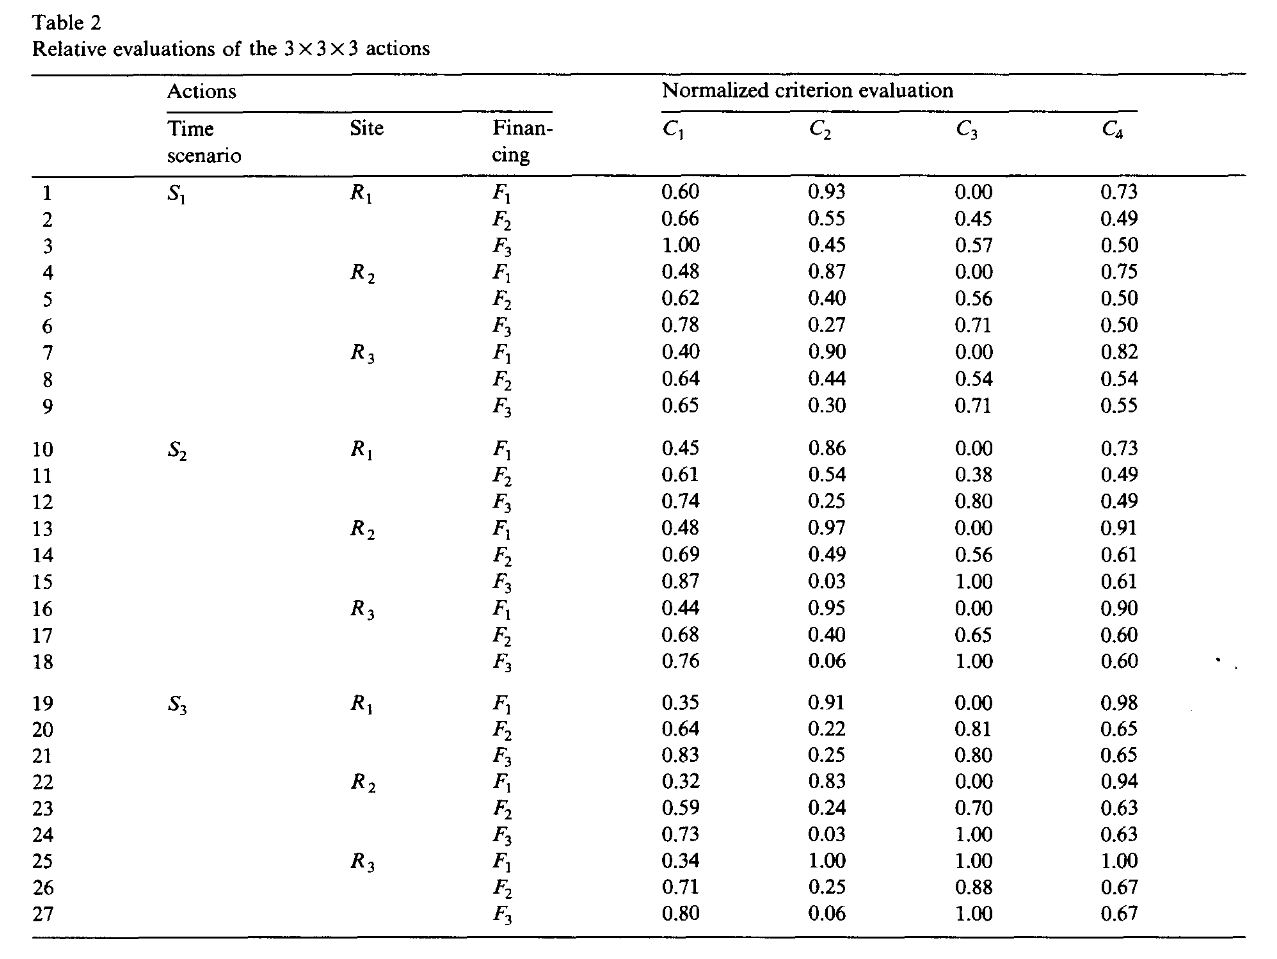

### Polityka firmy

Podczas tworzenia rankingu częściowego będziemy kierować się następującą polityką:

- Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie chcę brać pożyczek. (1)
- Preferowana jest lokalizacja R2 nad R1 oraz R1 nad R3. (4)

Drugi warunek jest łatwy do interpretacji - odnosi się jedynie do lokalizacji składowiska.

Pierwszy warunek odnosi się do metod finansowania przedsięwzięcia. Negatywnie oceniamy warianty z metodą finansowania F3, która zakłada wzięcie pożyczki. Znacznie wolimy metodę finansowania F1.

W przypadku konfliktu jako nadrzędne będziemy traktowali drugie kryterium, ponieważ jest konkretnie sformułowane.

### Pary wariantów referencyjnych

Utworzymy ranking częściowy poprzez porównanie parami następujących wariantów:

- wariant 12 i wariant 19
- wariant 11 i wariant 25
- wariant 1 i wariant 27
- wariant 1 i wariant 4
- wariant 19 i wariant 21

### Porównania parami

- $ 19 > 12 $, ponieważ warianty mają taką samą lokalizację (R1), a wariant 12 ma metodę finansowania, której chcemy unikać (F3)
- $ 11 > 25 $, ponieważ preferujemy lokalizację R1 nad R3
- $ 1 > 27 $, ponieważ preferujemy lokalizację R1 nad R3, a także metodę finansowania F1 nad F3
- $ 4 > 1 $, ponieważ preferujemy lokalizację R2 nad R1
- $ 19 > 21 $, ponieważ preferujemy metodę finansowania F1 nad F3

Minimalna waga każdego kryterium powinna wynosić 0,1. Nie nałożyliśmy więcej dodatkowych ograniczeń.

## Solver UTA

### Wczytanie danych

In [4]:
import pandas

data = pandas.read_csv("Nuclear waste management.csv")
data.columns = ["ID", "C1", "C2", "C3", "C4"]
display(data.style.hide())

ID,C1,C2,C3,C4
1,0.600000,0.930000,0.000000,0.730000
2,0.660000,0.550000,0.450000,0.490000
3,1.000000,0.450000,0.570000,0.500000
4,0.480000,0.870000,0.000000,0.750000
5,0.620000,0.400000,0.560000,0.500000
6,0.780000,0.270000,0.710000,0.500000
7,0.400000,0.900000,0.000000,0.820000
8,0.640000,0.440000,0.540000,0.540000
9,0.650000,0.300000,0.710000,0.550000
10,0.450000,0.860000,0.000000,0.730000


### Definicja problemu programowania matematycznego

In [5]:
!pip install pulp
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus, PULP_CBC_CMD

In [6]:
def create_uta_problem(data):
    """ 
    Funkcja definiująca zadany problem UTA.
    """
    # definicja funkcji celu
    prob = LpProblem("UTA", LpMaximize)
    e = LpVariable(name="e", lowBound=0, upBound=1)

    # utworzenie zmiennych decyzyjnych dla kryteriów
    criterion_vars = {}
    for column in data:
        if column != "ID":
            criterion_vars[column] = {val: LpVariable(f"{column}_{val}", lowBound=0, upBound=1) for val in data[column].values}

    # dodanie ograniczeń UTA
    sum_max = 0
    for column in data:
        if column != "ID":
            values = data[column].values.tolist()

            # monotoniczność - sortowanie rosnąco, kryterium typu koszt
            values.sort()
            for i in range(len(values) - 1):
                prob += criterion_vars[column][values[i]] >= criterion_vars[column][values[i+1]], f"Monotonicity_{column}_{i}"

            # dodatkowe ograniczenie - minimalna waga kryterium 0.1 - przyjmujemy ją dla najgorszej, czyli największej wartości
            max_val = max(values)
            prob += criterion_vars[column][max_val] == 0.1, f"Normalize_{column}_Lowest"

            # normalizacja - suma najlepszych wartości równa 100
            min_val = min(values)
            sum_max += criterion_vars[column][min_val] 
    prob += sum_max == 1, "Normalize_Criteria_Sum"

    # utworzenie zmiennych definiujących użyteczność wariantów
    utilities = []
    utilities.append(0) # warianty są numerowane od 1
    for i, variant in data.iterrows():
        u = LpVariable(f"U_{i+1}", lowBound=0)
        utilities.append(u)
        prob += u == lpSum([
            criterion_vars["C1"][variant["C1"]],
            criterion_vars["C2"][variant["C2"]],
            criterion_vars["C3"][variant["C3"]],
            criterion_vars["C4"][variant["C4"]]
        ]), f"Utility_{i+1}"

    # dodanie ograniczeń z porównań parami
    prob += utilities[19] >= utilities[12] + e, "Prefer_19_over_12"
    prob += utilities[11] >= utilities[25] + e, "Prefer_11_over_25"
    prob += utilities[1] >= utilities[27] + e, "Prefer_1_over_27"
    prob += utilities[4] >= utilities[1] + e, "Prefer_4_over_1"
    prob += utilities[19] >= utilities[21] + e, "Prefer_19_over_21"

    return prob, e, criterion_vars, utilities

### Rozwiązanie problemu

In [7]:
prob, e, criterion_vars, _ = create_uta_problem(data)
prob += e

prob.solve(PULP_CBC_CMD(msg=False))

1

In [8]:
print(f"Status: {LpStatus[prob.status]}")
print("\nWartość funkcji celu:", value(prob.objective))

Status: Optimal

Wartość funkcji celu: 0.25714286


### Ranking wariantów

Poniższa tabela przedstawia uzyskany ranking wraz z wartościami funkcji użyteczności oraz informacją, czy dany wariant był wykorzystany jako wariant referencyjny.

In [9]:
values = data["C1"].values.tolist()

ranking = [0 for i in range(len(values))]

for var in prob.variables():
    if var.name[0] == "U":
        number = int(var.name[2:])
        ranking[number-1] = value(var) 

is_reference = [0 for i in range(len(values))]
reference_variants = [1, 4, 11, 12, 19, 21, 25, 27]
for i in reference_variants:
    is_reference[i-1] = 1

data_sorted = data.copy(deep=True)
data_sorted['U'] = ranking
data_sorted['Referencyjny'] = is_reference
data_sorted = data_sorted.sort_values('U', ascending=False)

display(data_sorted.style.hide())

ID,C1,C2,C3,C4,U,Referencyjny
4,0.480000,0.870000,0.000000,0.750000,1.000000,1
10,0.450000,0.860000,0.000000,0.730000,1.000000,0
22,0.320000,0.830000,0.000000,0.940000,1.000000,0
16,0.440000,0.950000,0.000000,0.900000,0.914286,0
19,0.350000,0.910000,0.000000,0.980000,0.914286,1
13,0.480000,0.970000,0.000000,0.910000,0.914286,0
7,0.400000,0.900000,0.000000,0.820000,0.914286,0
11,0.610000,0.540000,0.380000,0.490000,0.828571,1
1,0.600000,0.930000,0.000000,0.730000,0.742857,1
23,0.590000,0.240000,0.700000,0.630000,0.657143,0


### Wykresy cząstkowych funkcji użyteczności

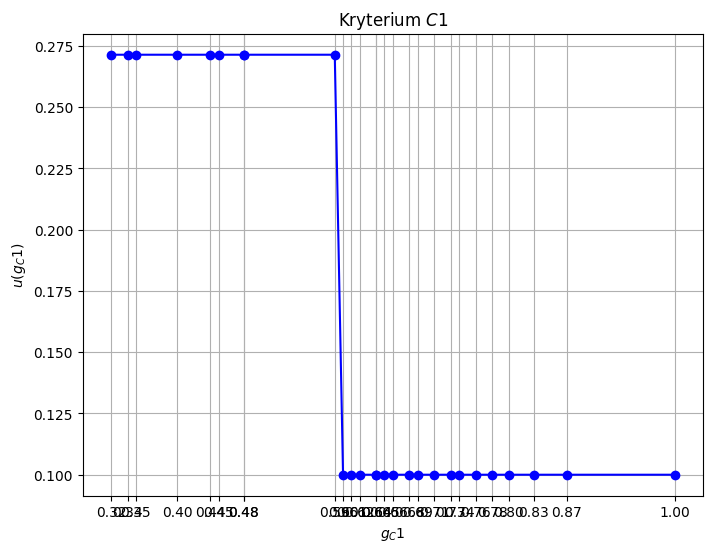

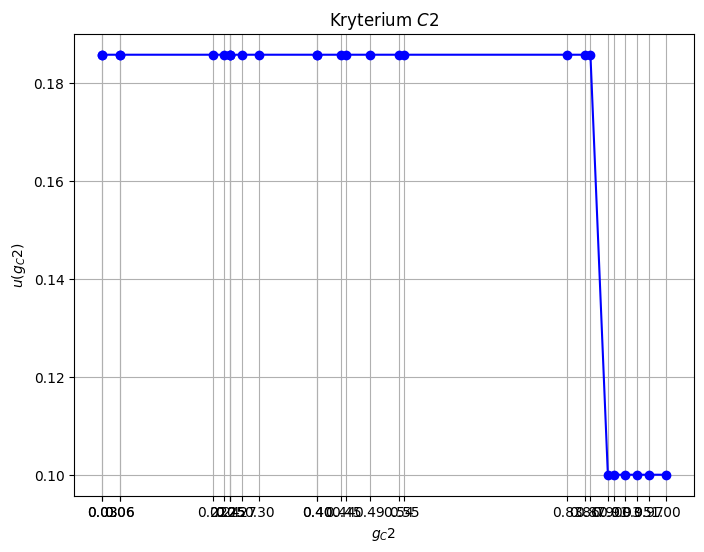

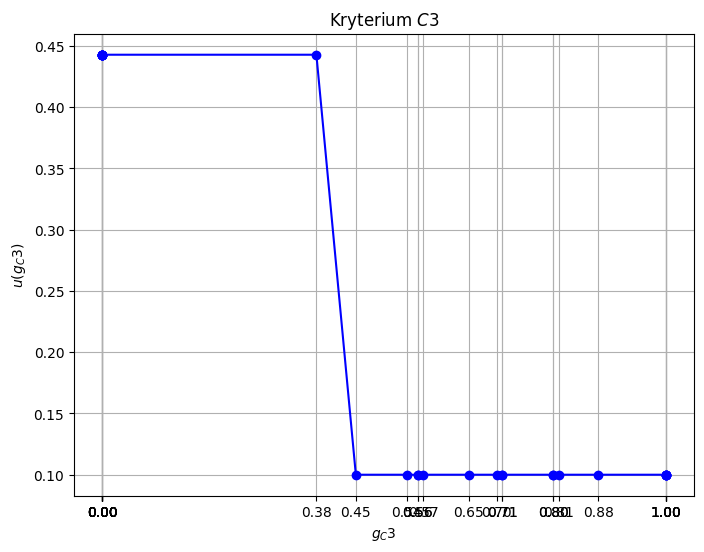

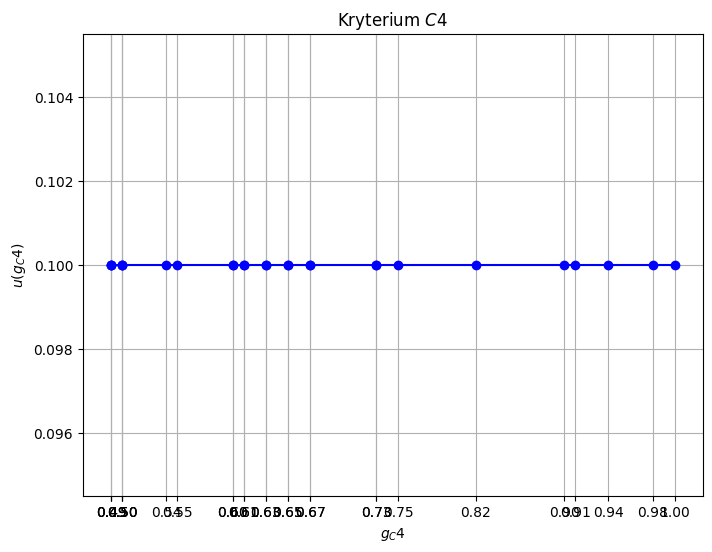

In [10]:
import matplotlib.pyplot as plt

for column in data.columns:
    if column in ["C1", "C2", "C3", "C4"]:
        values = data[column].values.tolist()
        values.sort()

        solver_values_C1 = [value(criterion_vars[column][val]) for val in values]

        plt.figure(figsize=(8, 6))
        plt.plot(values, solver_values_C1, marker='o', linestyle='-', color='b', label=f'$u(g_{column})$')
        plt.xlabel(f'$g_{column}$')
        plt.ylabel(f'$u(g_{column})$')
        plt.title(f'Kryterium ${column}$')
        plt.xticks(data[column].values)
        plt.grid(True)
        plt.show()

## Analiza wyników

### Zgodność wyników z informacją preferencyjną

Uzyskany ranking jest zgodny z rankingiem częściowym podanym w ramach informacji preferencyjnej.

- $ U(12) = 0,49 \land U(19) = 0,91 $, zatem $ 19 > 12 $
- $ U(11) = 0,83 \land U(25) = 0,57 $, zatem $ 11 > 25 $
- $ U(1) = 0,74 \land U(27) = 0,49 $, zatem $ 1 > 27 $
- $ U(4) = 1,00 \land U(1) = 0,74 $, zatem $ 4 > 1 $
- $ U(19) = 0,91 \land U(21) = 0,49 $, zatem $ 19 > 21 $

### Spójność z informacja preferencyjną dla wariantów niereferencyjnych

Warianty niereferencyjne w dużej mierze również uporządkowane są zgodnie z informacją preferencyjną, przykładowo:

- $ 13 > 23 $ - oba warianty mają lokalizację R2, natomiast wariant 13 ma preferowaną przez nas metodę finansowania F1
- $ 22 > 16 $ - wariant 22 ma lokalizację R2, a wariant 16 ma lokalizację R3
- $ 23 > 8 $ - wariant 23 ma lokalizację R2, a wariant 8 ma lokalizację R3

Wiele wariantów zostało jednak uznanych za nierozróżnialne.

### Najlepsze strategie

Najlepszą ocenę uzyskały trzy strategie:
- $ 4: S1 \times R2 \times F1 $
- $ 10: S2 \times R1 \times F1 $
- $ 22: S3 \times R2 \times F1 $

Wszystkie trzy charakteryzują się najbardziej preferowaną przez nas metodą finansowania F1, a dwa z nich mają także najbardziej preferowaną przez nas lokalizację R2.

### Najgorsze strategie

Jako najgorsze ocenione zostało aż 16 strategii. Są to w większości strategie charakteryzujące się najmniej przez nas preferowaną metodą finansowania F3 lub najmniej preferowaną lokalizacją R3.

### Wpływ kryteriów na ostateczny wynik

Największy wpływ na końcowy wynik miało kryterium C3, na którym waga dla najlepszych wartości jest równa prawie 0,45. 

Najmniejszy wpływ miało kryterium C4, które dla wszystkich wartości przyjęło minimalną wagę 0.1.

## UTA GMS

Za pomocą metody UTA GMS wyznaczymy, między którymi parami wariantów zachodzi relacja koniecznej lub możliwej preferencji.

### Solver

In [11]:
import numpy as np

variants = range(1, 28)
preference = np.full((len(variants)+1, len(variants)+1), ['x'], dtype=object)

for a in variants:
    for b in variants:
        if a == b:
            continue

        # relacja konieczna
        prob, e, criterion_vars, utilities = create_uta_problem(data)
        prob += e

        # sprawdzamy odwrotną relację b > a
        prob += utilities[b] >= utilities[a] + e, "Prefer_b_over_a"
        prob.solve(PULP_CBC_CMD(msg=False))
        if LpStatus[prob.status] == "Infeasible" or value(prob.objective) <= 0:
            preference[a][b] = 'N'
            continue

        # relacja możliwa
        prob, e, criterion_vars, utilities = create_uta_problem(data)
        prob += e
        
        # sprawdzamy relację a > b
        prob += utilities[a] >= utilities[b] + e, "Prefer_a_over_b"
        prob.solve(PULP_CBC_CMD(msg=False))
        if LpStatus[prob.status] == "Optimal" and value(prob.objective) >= 0:
            preference[a][b] = 'P'

### Relacje preferencji

Poniższa tabela przedstawia uzyskane relacje preferencji pomiędzy wariantami. "N" oznacza relację konieczną, "P" relację możliwą, a "x" brak relacji.

In [12]:
for i in range(0, 28):
    preference[i][0] = '-'
    preference[0][i] = '-'

np.set_printoptions(linewidth=200)
print(preference)

[['-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 ['-' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'N']
 ['-' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['-' 'P' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['-' 'N' 'P' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'N' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'N']
 ['-' 'P' 'P' 'N' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'N' 'P' 'P' 'N' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['-' 'P' 'P' 'P' 'P' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['-' 'P' 'P' 'P' 'P' 'P' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'N' 'P' 'P' 'N' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['-' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'x' 'P' 'P' 'P' 'P' 'P' 'N' 'P' 'P' 'P' 'P' 'P

### Diagram Hasse'go

Konieczną realizację preferencji przedstawiliśmy na diagramie Hasse'go.

In [13]:
!pip install graphviz
from graphviz import Digraph

In [14]:
from graphviz import Digraph
from collections import deque

def find(predecessor, node_id):
    if predecessor[node_id] != node_id:
        predecessor[node_id] = find(predecessor, predecessor[node_id])
    return predecessor[node_id]

def union(predecessor, node_id_a, node_id_b):
    root_a = find(predecessor, node_id_a)
    root_b = find(predecessor, node_id_b)

    if root_a != root_b:
        predecessor[root_a] = root_b 

def has_path(graph, start, end):
    if start == end:
        return True
    visited = set()
    queue = deque([start])

    while queue:
        node = queue.popleft()
        if node == end:
            return True
        if node not in visited:
            visited.add(node)
            queue.extend(graph.get(node, []))

    return False

def process_relations(data, outranks, indifferent, incomparable):
    """ 
    Funkcja tworząca diagram Hasse'go.
    """
    data = data.sort_values("ID")
    num_nodes = len(data)

    predecessor_indifferent = list(range(num_nodes + 1)) # indeksowanie od 1
    predecessor_incomparable = list(range(num_nodes + 1))

    # łączenie nierozróżnialnych wariantów
    for a, b in indifferent:
        union(predecessor_indifferent, a, b)

    for a, b in incomparable:
        union(predecessor_incomparable, a, b)

    outranking_graph = {i: [] for i in range(1, num_nodes + 1)}

    edges_added = set()
    
    # relacja preferencji
    for a, b in outranks:
        predecessor_a = find(predecessor_indifferent, a)
        predecessor_b = find(predecessor_indifferent, b)

        if predecessor_a != predecessor_b and (predecessor_a, predecessor_b) not in edges_added:
            outranking_graph[predecessor_a].append(predecessor_b)
            edges_added.add((predecessor_a, predecessor_b))

    edges_added2 = set()

    edges = []
    for a, b in outranks:
        predecessor_a = find(predecessor_indifferent, a)
        predecessor_b = find(predecessor_indifferent, b)
        if predecessor_a != predecessor_b and (predecessor_a, predecessor_b) not in edges_added2:
            edges.append((predecessor_a, predecessor_b))
            edges_added2.add((predecessor_a, predecessor_b))

    dgraph = Digraph(format="png")
    dgraph.attr(rankdir="TB")

    node_groups = {}

    for node_id in data["ID"]:
        root = find(predecessor_indifferent, node_id)
        if root not in node_groups:
            node_groups[root] = []
        node_groups[root].append(node_id)

    # zaznaczenie wariantów nierozróżnialnych
    for root, nodes in node_groups.items():
        node_label = "~".join(map(str, sorted(nodes)))
        dgraph.node(str(root), label=node_label, shape="circle", style="filled", fillcolor="lightgray")

    # usunięcie krawędzi wynikających z relacji przechodnich
    for a, b in edges:
        outranking_graph[a].remove(b)
        if not has_path(outranking_graph, a, b):
            dgraph.edge(str(a), str(b))
        outranking_graph[a].append(b)

    display(dgraph)

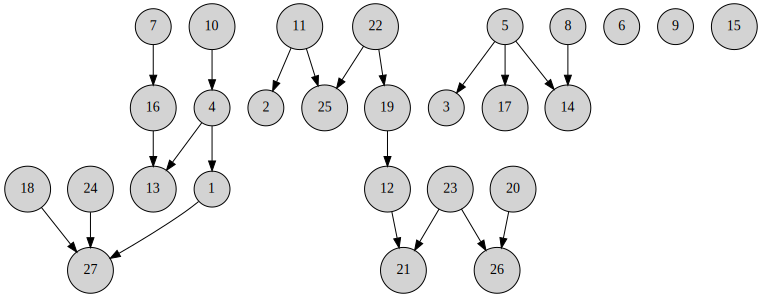

In [15]:
outranks = []
indifferent = []
incomparable = []

for a in variants:
    for b in variants:
        if preference[a][b] == 'N':
            outranks.append((a,b))

process_relations(data, outranks, indifferent, incomparable)

### Opis uzyskanych relacji

Warianty 10 i 22, uznane za jedne z najlepszych w rankingu wygenerowanym za pomocą metody UTA, są koniecznie preferowane nad cztery inne warianty, co stanowi najwyższy wynik.

Co ciekawe, wariant 10 jest koniecznie preferowany nad wariant 4, który również był uznany za jeden z najlepszych. Zgodnie z definicją relacji koniecznej preferencji, oznacza to, że wariant 4 nie był samodzielnie uznany za najlepszy w żadnej z funkcji ze zbioru funkcji użyteczności spójnych z preferencjami decydenta - mógł uzyskać największą wartość funkcji użyteczności tylko wtedy, kiedy wariant 10 również ją uzyskał.

Większość pozostałych wariantów powiązanych jest relacją koniecznej preferencji z jednym innym wariantem. Warianty 6, 9 i 15 nie są połączone łukiem z żadnym innym wariantem.

Aby zwiększyć czytelność diagramu, usunęliśmy z niego łuki wynikające z relacji przechodnich.

## Reprezentatywna funkcja użyteczności

### Solver

In [16]:
# maksymalizujemy M*e - d
prob, e, criterion_vars, utilities = create_uta_problem(data)
d = LpVariable(name="d", lowBound=0, upBound=1)
prob += 1000*e - d

# ograniczenia wynikające z koniecznej relacji preferencji
for a in variants:
    for b in variants:
        if b >= a:
            continue

        if preference[a][b] == 'N' and preference[b][a] != 'N':
            prob += utilities[a] >= utilities[b] + e

        elif preference[a][b] != 'N' and preference[b][a] != 'N':
            prob += utilities[a] - utilities[b] <= d
            prob += utilities[b] - utilities[a] <= d

prob.solve(PULP_CBC_CMD(msg=False))

1

In [17]:
print(f"Status: {LpStatus[prob.status]}")
print("\nWartość funkcji celu:", value(prob.objective))

Status: Optimal

Wartość funkcji celu: 149.55


### Ranking

In [18]:
values = data["C1"].values.tolist()

ranking = [0 for i in range(len(values))]

for var in prob.variables():
    if var.name[0] == "U":
        number = int(var.name[2:])
        ranking[number-1] = value(var) 

is_reference = [0 for i in range(len(values))]
reference_variants = [1, 4, 11, 12, 19, 21, 25, 27]
for i in reference_variants:
    is_reference[i-1] = 1

data['U'] = ranking
data['Referencyjny'] = is_reference
data_sorted = data.sort_values('U', ascending=False)

display(data_sorted.style.hide())

ID,C1,C2,C3,C4,U,Referencyjny
10,0.450000,0.860000,0.000000,0.730000,1.000000,0
22,0.320000,0.830000,0.000000,0.940000,1.000000,0
4,0.480000,0.870000,0.000000,0.750000,0.850000,1
7,0.400000,0.900000,0.000000,0.820000,0.850000,0
16,0.440000,0.950000,0.000000,0.900000,0.850000,0
19,0.350000,0.910000,0.000000,0.980000,0.850000,1
11,0.610000,0.540000,0.380000,0.490000,0.850000,1
13,0.480000,0.970000,0.000000,0.910000,0.700000,0
5,0.620000,0.400000,0.560000,0.500000,0.700000,0
1,0.600000,0.930000,0.000000,0.730000,0.700000,1


### Wykresy cząstkowych funkcji użyteczności

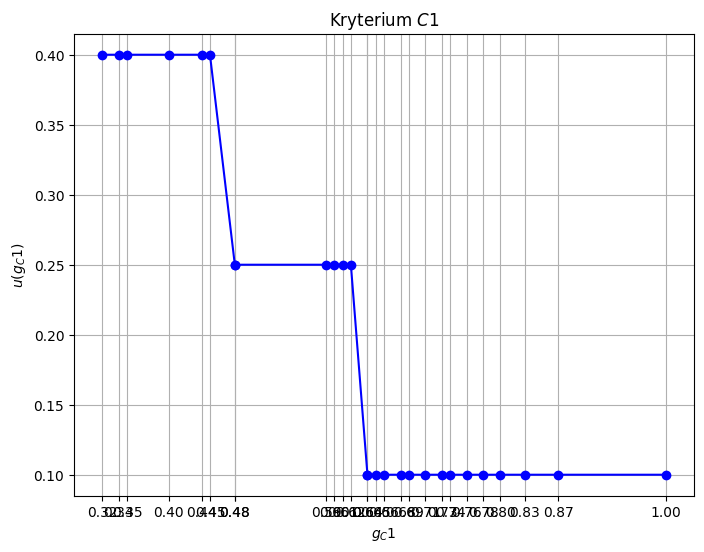

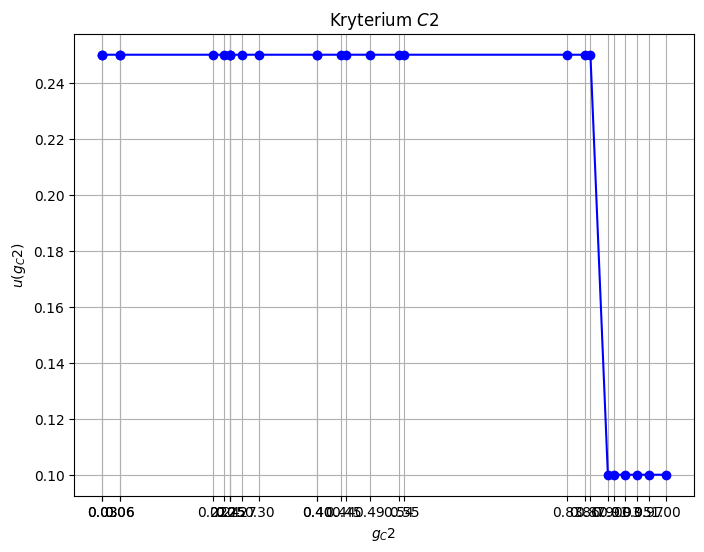

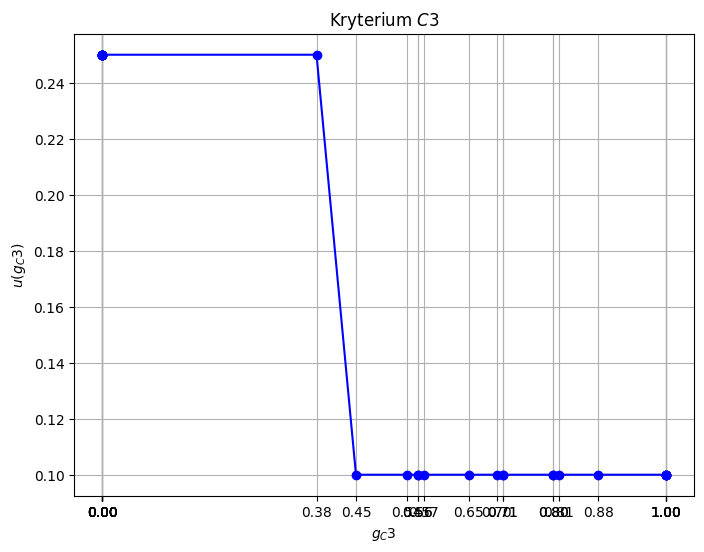

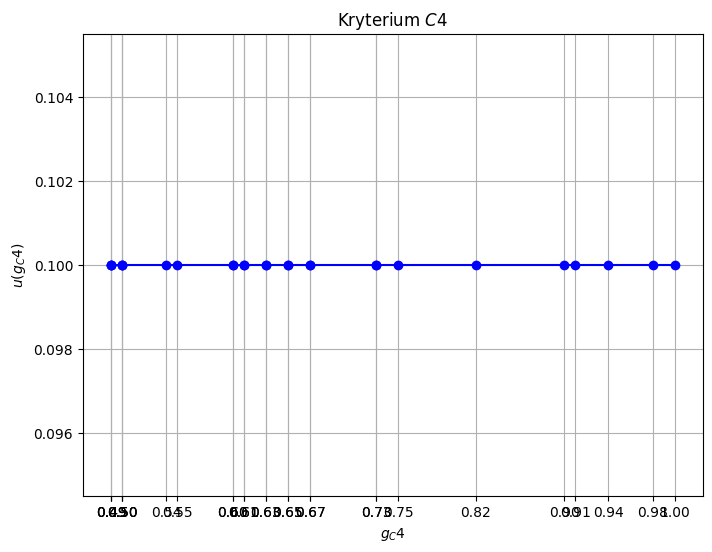

In [19]:
import matplotlib.pyplot as plt

for column in data.columns:
    if column in ["C1", "C2", "C3", "C4"]:
        values = data[column].values.tolist()
        values.sort()

        solver_values_C1 = [value(criterion_vars[column][val]) for val in values]

        plt.figure(figsize=(8, 6))
        plt.plot(values, solver_values_C1, marker='o', linestyle='-', color='b', label=f'$u(g_{column})$')
        plt.xlabel(f'$g_{column}$')
        plt.ylabel(f'$u(g_{column})$')
        plt.title(f'Kryterium ${column}$')
        plt.xticks(data[column].values)
        plt.grid(True)
        plt.show()

### Porównanie wyników z metodą UTA

Wyniki uzyskane dla reprezentatywnej funkcji użyteczności są podobne do wyników uzyskanych za pomocą standardowej metody UTA.

Na szczycie obu rankingów znalazły się warianty 10 i 22, które są także koniecznie preferowane nad największą liczbę wariantów zgodnie z wynikami UTA GMS.

Obie metody doprowadziły do uzyskania rankingu zawierającego dużą liczbę wariantów nierozróżnialnych, zwłaszcza w dolnej połowie rankingu.

Kształt wykresów cząstkowych funkcji użyteczności również nie zmienił się zbytnio względem metody UTA. Dodatkowe punkty charakterystyczne możemy zauważyć jedynie na wykresie dla kryterium C1. 

Dla standardowej metody UTA największą wagę miało kryterium C3, natomiast w przypadku reprezentatywnej funkcji użyteczności największą wagę ma kryterium C1. Kryterium C4 ponownie ma minimalny wpływ na uzyskaną funkcję użyteczności.